# Meshing Australia

In this notebook we:

1. Import a coastline from an ESRI shapefile
2. Sample its interior using the poisson disc generator
3. Resample the interior using a DEM
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools
import shapefile
from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from osgeo import gdal
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
def remove_duplicates(a):
    """
    find unique rows in numpy array 
    <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
    """
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
    return dedup

coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
shapeRecs = coast_shape.shapeRecords()
coords = []
for record in shapeRecs:
    coords.append(record.shape.points[:])
    
coords = np.vstack(coords)

# Remove duplicates
points = remove_duplicates(coords)

In [3]:
gtiff = gdal.Open("data/ausbath_09_v4.tiff")
width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
minX = gt[0]
minY = gt[3] + width*gt[4] + height*gt[5] 
maxX = gt[0] + width*gt[1] + height*gt[2]
maxY = gt[3]

img = gtiff.GetRasterBand(1).ReadAsArray()
img = np.flipud(img).astype(float)

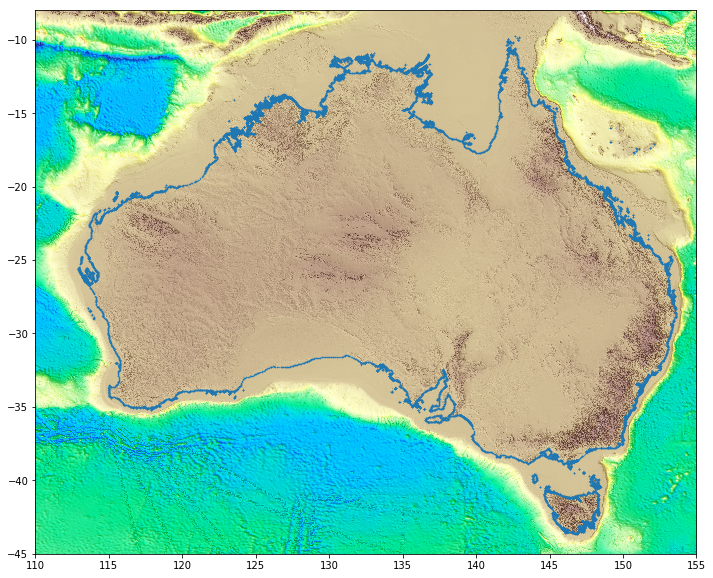

In [4]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(img, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='lower')
ax.scatter(points[:,0], points[:,1], s=0.1)
plt.show()

## 2. Poisson disc sampler

We need seed points to initiate the poisson disc generator within the coastline of mainland Australia and Tasmania.
Also, we add extra points around the coastline to prevent the flood fill algorithm to sample any ocean.

In [5]:
points2 = points.copy()
points2[:,1] -= 0.1

points3 = points.copy()
points3[:,0] -= 0.1

cpts = np.vstack((points, points2, points3))
spts = np.array([[135., -25.], [147., -42.5]])

sample_pts, bmask = meshtools.poisson_disc_sampler(minX, maxX, minY, maxY, 0.2, cpts=cpts, spts=spts)

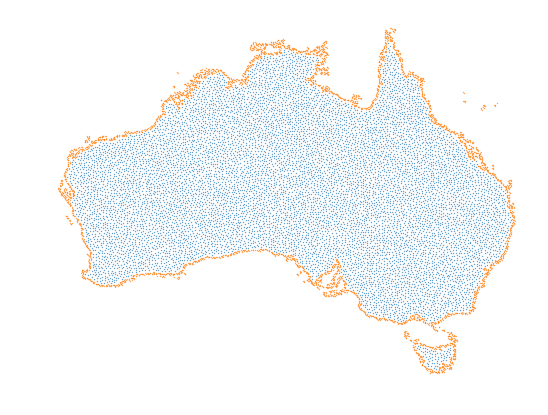

In [6]:
fig = plt.figure(1, figsize=(9,7))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(sample_pts[bmask,0], sample_pts[bmask,1], s=0.1)
ax.scatter(sample_pts[~bmask,0], sample_pts[~bmask,1], s=0.1)
plt.show()

## 3. Refined poisson disc sampler

We resample the points from a minimum radius field based on the topography of Australia.

The minimum radius field is created by smoothing the DEM we imported earlier, then rescaling the array to an appropriate radius. The radius field should always be greater than zero and an appropriate resolution (keeping in mind we will refine the points further after we create the DM).

In [7]:
gradX, gradY = np.gradient(img)
smooth_derivative = gaussian_filter(np.hypot(gradX, gradY), 50.)

r_min = 0.02
r_scale = 0.25

rgrid = -smooth_derivative
rgrid -= rgrid.min()
rgrid = r_scale*rgrid/rgrid.max() + r_min

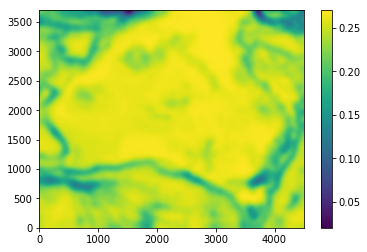

In [8]:
plt.imshow(rgrid, origin='lower')
plt.colorbar()

In [9]:
points2 = points.copy()
points2[:,1] += 0.1

points3 = points.copy()
points3[:,0] += 0.1

# we require thicker set of constraint points (coasts have very small radius)
cpts2 = np.vstack((cpts, points2, points3))

In [10]:
sample_pts2, bmask = meshtools.poisson_disc_sampler(minX, maxX, minY, maxY, None, r_grid=rgrid, cpts=cpts2, spts=spts)
print("number of points {}".format(sample_pts2.shape[0]))

number of points 9080


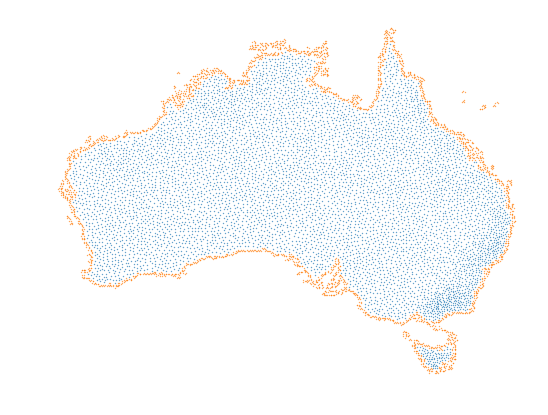

In [11]:
fig = plt.figure(1, figsize=(9,7))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(sample_pts2[bmask,0], sample_pts2[bmask,1], s=0.1)
ax.scatter(sample_pts2[~bmask,0], sample_pts2[~bmask,1], s=0.1)
plt.show()

## 4. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [12]:
pts = sample_pts2
DM = meshtools.create_DMPlex_from_points(pts[:,0], pts[:,1], bmask, refinement_steps=1)

In [13]:
mesh = quagmire.FlatMesh(DM)

 - Delaunay triangulation 0.070837s
 - cKDTree 0.011144s
 - Calculate node weights and area 0.700689s
 - Compute edge lengths 0.063267s
 - Construct nearest neighbour array 0.290847s
 - Find boundaries 0.003456s
 - Build smoothing matrix 0.152256s
 - Construct neighbour cloud array 0.175003s
 - Construct rbf weights 0.032538s


## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [14]:
mesh.save_mesh_to_hdf5('austopo.h5')